# Posterior Estimation for SIR-like Models

## Table of Contents
 * [Introduction](#introduction)
 * [Defining the Generative Model](#defining_the_generative)
	 * [Prior](#prior)
	 * [Simulator (Implicit Likelihood Function)](#simulator__implicit_likelihood)
	 * [Loading Real Data](#loading_real_data)
	 * [Generative Model](#generative_model)
 * [Prior Checking](#prior_checking)
 * [Defining the Neural Approximator](#defining_the_neural)
	 * [Summary Network](#summary_network)
	 * [Inference Network](#inference_network)
	 * [Amortized Posterior](#amortized_posterior)
 * [Defining the Configurator](#defining_the_configurator)
 * [Defining the Trainer](#defining_the_trainer)
 * [Training Phase](#training_phase)
	 * [Inspecting the Loss](#inspecting_the_loss)
 * [Validation Phase](#validation_phase)
	 * [Inspecting the Latent Space](#inspecting_the_latent)
	 * [Simulation-Based Calibration - Rank Histograms](#simulation_based_calibration__)
	 * [Simulation-Based Calibration - Rank ECDF](#simulation_based_calibration___0)
	 * [Inferential Adequacy (Global)](#inferential_adequacy__global_)
 * [Inference Phase](#inference_phase)
	 * [Bivariate Posteriors](#bivariate_posteriors)
		 * [Standalone](#standalone)
		 * [Compared to Prior](#compared_to_prior)
	 * [Posterior Retrodictive Checks](#posterior_retrodictive_checks)

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import keras

# For BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

## Introduction <a class="anchor" id="introduction"></a>

In this tutorial, we will illustrate how to perform posterior inference on simple, stationary SIR-like models (complex models will be tackled in a further notebook). SIR-like models comprise suitable illustrative examples, since they generate time-series and their outputs represent the results of solving a system of ordinary differential equations (ODEs).

The details for tackling stochastic epidemiological models with neural networks are described in our corresponding paper, which you can consult for a more formal exposition and a more comprehensive treatment of neural architectures:

<em>OutbreakFlow: Model-based Bayesian inference of disease outbreak dynamics with invertible neural networks and its application to the COVID-19 pandemics in Germany</em> https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009472

## Defining the Simulator <a class="anchor" id="defining_the_generative"></a>

In [2]:
RNG = np.random.default_rng(2024)

As described in our [very first notebook](Intro_Amortized_Posterior_Estimation.ipynb), a generative model consists of a prior (encoding suitable parameter ranges) and a simulator (generating data given simulations). Our underlying model distinguishes between susceptible, $S$, infected, $I$, and recovered, $R$, individuals with infection and recovery occurring at a constant transmission rate $\lambda$ and constant recovery rate $\mu$, respectively. The model dynamics are governed by the following system of ODEs:

$$
\begin{align}
    \frac{dS}{dt} &= -\lambda\,\left(\frac{S\,I}{N}\right) \\
    \frac{dI}{dt} &= \lambda\,\left(\frac{S\,I}{N}\right) - \mu\,I \\
    \frac{dR}{dt} &= \mu\,I,
\end{align}
$$

with $N = S + I + R$ denoting the total population size. For the purpose of forward inference (simulation), we will use a time step of $dt = 1$, corresponding to daily case reports. In addition to the ODE parameters $\lambda$ and $\mu$, we consider a reporting delay parameter $L$ and a dispersion parameter $\psi$, which affect the number of reported infected individuals via a negative binomial disttribution (https://en.wikipedia.org/wiki/Negative_binomial_distribution):

$$
\begin{equation}
    I_t^{(obs)} \sim \textrm{NegBinomial}(I^{(new)}_{t-L}, \psi),
\end{equation}
$$

In this way, we connect the latent disease model to an observation model, which renders the relationship between parameters and data a stochastic one. Note, that the observation model induces a further parameter $\psi$, responsible for the dispersion of the noise.
Finally, we will also treat the number of initially infected individuals, $I_0$ as an unknown parameter (having its own prior distribution).

### Prior <a class="anchor" id="prior"></a>

We will place the following prior distributions over the five model parameters, summarized in the table below:

$$
\begin{aligned}
& \text {Table 1. Description of model parameters and corresponding prior distributions}\\
&\begin{array}{lcl}
\hline \hline \text { Description} & \text { Symbol } & \text { Prior Distribution } \\
\hline \hline \text{Initial transmission rate} & \text{$\lambda$} & \text{$\textrm{LogNormal}(\log(0.4), 0.5)$} \\
\text{Recovery rate of infected individuals} & \text{$\mu$} & \text{$\textrm{LogNormal}(\log(1/8), 0.2)$} \\
\text{Reporting delay (lag)} & \text{$L$} & \text{$\textrm{LogNormal}(\log(8), 0.2)$} \\
\text{Number of initially infected individuals} & \text{$I_0$} & \text{$\textrm{Gamma}(2, 20)$} \\
\text{Dispersion of the negative binomial distribution} & \text{$\psi$} & \text{$\textrm{Exponential}(5)$} \\
\hline
\end{array}
\end{aligned}
$$

How did we come up with these priors? In this case, we rely on the domain expertise and previous research by https://www.science.org/doi/10.1126/science.abb9789. In addition, the new parameter $\psi$ follows an exponential distribution, which restricts it to positive numbers. Below is the implementation of these priors:

In [3]:
def prior():
    """Generates a random draw from the joint prior."""

    lambd = RNG.lognormal(mean=np.log(0.4), sigma=0.5)
    mu = RNG.lognormal(mean=np.log(1 / 8), sigma=0.2)
    D = RNG.lognormal(mean=np.log(8), sigma=0.2)
    I0 = RNG.gamma(shape=2, scale=20)
    psi = RNG.exponential(5)
    return dict(parameters=np.array([lambd, mu, D, I0, psi]))

### Observation Model (Implicit Likelihood Function) <a class="anchor" id="simulator__implicit_likelihood"></a>

In [4]:
from scipy.stats import nbinom


def convert_params(mu, phi):
    """Helper function to convert mean/dispersion parameterization of a negative binomial to N and p,
    as expected by numpy's negative_binomial.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """

    r = phi
    var = mu + 1 / r * mu**2
    p = (var - mu) / var
    return r, 1 - p


def stationary_SIR(parameters, N=83e6, T=14, eps=1e-5):
    """Performs a forward simulation from the stationary SIR model given a random draw from the prior."""

    # Extract parameters and round I0 and D
    lambd, mu, D, I0, psi = parameters
    I0 = np.ceil(I0)
    D = int(round(D))

    # Initial conditions
    S, I, R = [N - I0], [I0], [0]

    # Reported new cases
    C = [I0]

    # Simulate T-1 timesteps
    for t in range(1, T + D):
        # Calculate new cases
        I_new = lambd * (I[-1] * S[-1] / N)

        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu * I[-1], 0.0, N)
        R_t = np.clip(R[-1] + mu * I[-1], 0.0, N)

        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C.append(I_new)

    reparam = convert_params(np.clip(np.array(C[D:]), 0, N) + eps, psi)
    C_obs = RNG.negative_binomial(reparam[0], reparam[1])
    return dict(cases=C_obs[:, np.newaxis])

As you can see, in addition to the parameters, our simulator requires two further arguments: the total population size $N$ and the time horizon $T$. These are quantities over which we can amortize (i.e., context variables), but for this example, we will just use the population of Germany and the first two weeks of the pandemics (i.e., $T=14$), in the same vein as https://www.science.org/doi/10.1126/science.abb9789.

### Loading Real Data <a class="anchor" id="loading_real_data"></a>

We will define a simple helper function to load the actually reported cases in 2020 for the first two weeks of the Covid-19 pandemic in Germany.

In [5]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

### Stitiching Things Together <a class="anchor" id="generative_model"></a>
We can combine the prior $p(\theta)$ and the observation model $p(x_{1:T}\mid\theta)$ into a a joint model $p(\theta, x_{1:T}) = p(\theta)p(x_{1:T}\mid\theta)$ using the `make_simulator` builder.
The resulting object can now generate *batches* of simulations.

In [9]:
simulator = bf.make_simulator([prior, stationary_SIR])

In [11]:
%%time
test_sims = simulator.sample(batch_size=2)
print(test_sims["parameters"].shape)
print(test_sims["cases"].shape)

(2, 5)
(2, 14, 1)
CPU times: total: 0 ns
Wall time: 1 ms


## Prior Checking <a class="anchor" id="prior_checking"></a>

Any principled Bayesian workflow requires some prior predictive or prior pushforward checks to ensure that the prior specification is consistent with domain expertise (see https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html). The BayesFlow library provides some rudimentary visual tools for performing prior checking. For instance, we can visually inspect the joint prior in the form of bivariate plots:

C:\Users\radevs\AppData\Local\anaconda3\envs\bf\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


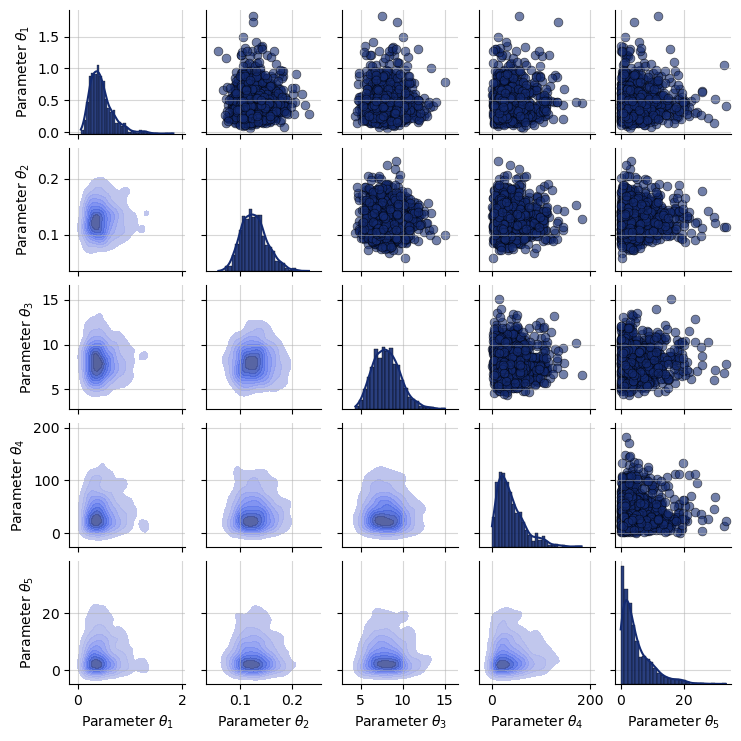

In [26]:
prior_samples = simulator.simulators[0].sample(1000)

grid = bf.diagnostics.plot_samples_2d(prior_samples["parameters"], context="Parameter", height=1.5)

## Defining the Adapter

We need to ensure that the outputs of the forward model are suitable for processing with neural networks. Currently, they are not, since our data $x_{1:T}$ consists of large integer (count) values. However, neural networks like scaled data. Furthermore, our parameters $\theta$ exhibit widely different scales due to their prior specification and role in the simulator. Finally, BayesFlow needs to know which variables are to be inferred and which ones are to be processed by the summary network before being passed to the inference network. We handle all of these steps using an `Adapter`.

Since all of our parameters and observables can only take on positive values, we will apply a log plus one transform to all quantities. Note, that `BayesFlow` expects the following keys to be present in the final outputs of your configured simulations:
- `inference_variables` - these are the variables we are inferring.
- `summary_variables` - these are the variables that are compressed throgh a summary network and used for inferring the `inference_variables`.

Thus, what our approximators are learning is $p(\text{inference_variables} \mid t(\text{summary_variables}))$, where $t$ is the summary network.

In [51]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .apply(forward=lambda x: np.log1p(x), inverse=lambda x: np.expm1(x))
    .rename("parameters", "inference_variables")
    .rename("cases", "summary_variables")
)

## Defining the Neural Approximator <a class="anchor" id="defining_the_neural"></a>

We can now proceed to define our `BayesFlow` neural architecture, that is, combine a summary network with an inference network.

### Summary Network <a class="anchor" id="summary_network"></a>

Since our simulator outputs 3D tensors of shape ``(batch_size, T = 14, 1)``, we need to reduce this three-dimensional tensor into a two-dimensional tensor of shape ``(batch_size, summary_dim)``. Our model outputs are actually so simple that we could have just removed the trailing dimension of the raw outputs and simply fed the data directly to the inference network.

However, we demonstrate the use of a simple Gated Recurrent Unit (GRU) summary network. Any `keras` model can interact with `BayesFlow` by inherting from `SummaryNetwork` which accepts an addition `stage` argument indicating the mode the network is currently operating in (i.e., `training` vs. `inference`).

In [91]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

In [84]:
summary_net = GRU()

### Inference Network <a class="anchor" id="inference_network"></a>

In [99]:
inference_net = bf.networks.FlowMatching(
    subnet_kwargs={"residual": True, "dropout": 0.1}
)

### Amortized Posterior <a class="anchor" id="amortized_posterior"></a>

We can now connect the summary and inference networks via the `ContinuousApproximator` wrapper:

In [86]:
approximator = bf.approximators.ContinuousApproximator(
    inference_network=inference_net, 
    summary_network=summary_net,
    adapter=adapter
)

## Training <a class="anchor" id="training"></a>

Ready to train! Since our simulator is pretty fast, we can safely go with online training. Let's glean the time taken for a batch of $32$ simulations.

In [87]:
%%time
_ = simulator.sample(32)

CPU times: total: 15.6 ms
Wall time: 14.3 ms


Not too bad! However, for the purpose of illustration, we will go with offline training using a fixed data set of simulations.

### Generating Offline Data <a class="anchor" id="generating_offline_data"></a>

In [100]:
batch_size = 128
epochs = 500 # Flow matching profits from longer training

training_dataset = bf.datasets.OfflineDataset(
    data=simulator.sample((5000,)), 
    batch_size=batch_size, 
    adapter=adapter
)

validation_dataset = bf.datasets.OfflineDataset(
    data=simulator.sample((300,)), 
    batch_size=batch_size, 
    adapter=adapter
)

### Definining an Optimizer

In [101]:
initial_learning_rate = 5e-4
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=epochs*training_dataset.num_batches,
    alpha=1e-8
)

optimizer = keras.optimizers.AdamW(learning_rate=scheduled_lr)

### Compile and Train the Approximator

In [102]:
approximator.compile(optimizer=optimizer)


history = approximator.fit(
    epochs=epochs,
    dataset=training_dataset,
    validation_data=validation_dataset,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Epoch 1/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.4652 - loss/inference_loss: 0.4652 - val_loss: 0.4791 - val_loss/inference_loss: 0.4791
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3933 - loss/inference_loss: 0.3933 - val_loss: 0.3022 - val_loss/inference_loss: 0.3022
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3810 - loss/inference_loss: 0.3810 - val_loss: 0.3281 - val_loss/inference_loss: 0.3281
Epoch 4/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3697 - loss/inference_loss: 0.3697 - val_loss: 0.3619 - val_loss/inference_loss: 0.3619
Epoch 5/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3714 - loss/inference_loss: 0.3714 - val_loss: 0.4471 - val_loss/inference_loss: 0.4471
Epoch 6/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3756 - loss/inference_loss: 0.3756 - val_loss: 0.3859 - val_loss/inference_loss: 0.3859
Epoch 7/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3999 - loss/inference_loss: 0.3999 - val_los

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3716 - loss/inference_loss: 0.3716 - val_loss: 0.3929 - val_loss/inference_loss: 0.3929
Epoch 46/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3640 - loss/inference_loss: 0.3640 - val_loss: 0.4004 - val_loss/inference_loss: 0.4004
Epoch 47/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3653 - loss/inference_loss: 0.3653 - val_loss: 0.4365 - val_loss/inference_loss: 0.4365
Epoch 48/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3777 - loss/inference_loss: 0.3777 - val_loss: 0.3376 - val_loss/inference_loss: 0.3376
Epoch 49/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3659 - loss/inference_loss: 0.3659 - val_loss: 0.3981 - val_loss/inference_loss: 0.3981
Epoch 50/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3699 - loss/inference_loss: 0.3699 - val_loss: 0.3764 - val_loss/inference_loss: 0.3764
Epoch 51/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3624 - loss/inference_loss: 0.3624 - val_loss: 0.40

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3500 - loss/inference_loss: 0.3500 - val_loss: 0.3578 - val_loss/inference_loss: 0.3578
Epoch 90/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3556 - loss/inference_loss: 0.3556 - val_loss: 0.3121 - val_loss/inference_loss: 0.3121
Epoch 91/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3603 - loss/inference_loss: 0.3603 - val_loss: 0.2772 - val_loss/inference_loss: 0.2772
Epoch 92/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3541 - loss/inference_loss: 0.3541 - val_loss: 0.4178 - val_loss/inference_loss: 0.4178
Epoch 93/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3576 - loss/inference_loss: 0.3576 - val_loss: 0.3535 - val_loss/inference_loss: 0.3535
Epoch 94/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3669 - loss/inference_loss: 0.3669 - val_loss: 0.4067 - val_loss/inference_loss: 0.4067
Epoch 95/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3802 - loss/inference_loss: 0.3802 - val_loss: 0.30

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3439 - loss/inference_loss: 0.3439 - val_loss: 0.3605 - val_loss/inference_loss: 0.3605
Epoch 134/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3511 - loss/inference_loss: 0.3511 - val_loss: 0.3330 - val_loss/inference_loss: 0.3330
Epoch 135/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3436 - loss/inference_loss: 0.3436 - val_loss: 0.2957 - val_loss/inference_loss: 0.2957
Epoch 136/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3634 - loss/inference_loss: 0.3634 - val_loss: 0.4543 - val_loss/inference_loss: 0.4543
Epoch 137/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3470 - loss/inference_loss: 0.3470 - val_loss: 0.3822 - val_loss/inference_loss: 0.3822
Epoch 138/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3467 - loss/inference_loss: 0.3467 - val_loss: 0.3096 - val_loss/inference_loss: 0.3096
Epoch 139/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3551 - loss/inference_loss: 0.3551 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3326 - loss/inference_loss: 0.3326 - val_loss: 0.3376 - val_loss/inference_loss: 0.3376
Epoch 178/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3633 - loss/inference_loss: 0.3633 - val_loss: 0.3581 - val_loss/inference_loss: 0.3581
Epoch 179/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3560 - loss/inference_loss: 0.3560 - val_loss: 0.3172 - val_loss/inference_loss: 0.3172
Epoch 180/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3325 - loss/inference_loss: 0.3325 - val_loss: 0.4282 - val_loss/inference_loss: 0.4282
Epoch 181/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3514 - loss/inference_loss: 0.3514 - val_loss: 0.4596 - val_loss/inference_loss: 0.4596
Epoch 182/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3397 - loss/inference_loss: 0.3397 - val_loss: 0.3685 - val_loss/inference_loss: 0.3685
Epoch 183/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3384 - loss/inference_loss: 0.3384 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3362 - loss/inference_loss: 0.3362 - val_loss: 0.3446 - val_loss/inference_loss: 0.3446
Epoch 222/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3387 - loss/inference_loss: 0.3387 - val_loss: 0.2833 - val_loss/inference_loss: 0.2833
Epoch 223/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3363 - loss/inference_loss: 0.3363 - val_loss: 0.4573 - val_loss/inference_loss: 0.4573
Epoch 224/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3413 - loss/inference_loss: 0.3413 - val_loss: 0.4111 - val_loss/inference_loss: 0.4111
Epoch 225/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3402 - loss/inference_loss: 0.3402 - val_loss: 0.4442 - val_loss/inference_loss: 0.4442
Epoch 226/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3464 - loss/inference_loss: 0.3464 - val_loss: 0.3112 - val_loss/inference_loss: 0.3112
Epoch 227/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3336 - loss/inference_loss: 0.3336 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3537 - loss/inference_loss: 0.3537 - val_loss: 0.4049 - val_loss/inference_loss: 0.4049
Epoch 266/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3303 - loss/inference_loss: 0.3303 - val_loss: 0.3664 - val_loss/inference_loss: 0.3664
Epoch 267/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3304 - loss/inference_loss: 0.3304 - val_loss: 0.3572 - val_loss/inference_loss: 0.3572
Epoch 268/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3345 - loss/inference_loss: 0.3345 - val_loss: 0.4357 - val_loss/inference_loss: 0.4357
Epoch 269/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3432 - loss/inference_loss: 0.3432 - val_loss: 0.4177 - val_loss/inference_loss: 0.4177
Epoch 270/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3394 - loss/inference_loss: 0.3394 - val_loss: 0.3098 - val_loss/inference_loss: 0.3098
Epoch 271/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3387 - loss/inference_loss: 0.3387 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3327 - loss/inference_loss: 0.3327 - val_loss: 0.2569 - val_loss/inference_loss: 0.2569
Epoch 310/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3353 - loss/inference_loss: 0.3353 - val_loss: 0.3879 - val_loss/inference_loss: 0.3879
Epoch 311/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3334 - loss/inference_loss: 0.3334 - val_loss: 0.3131 - val_loss/inference_loss: 0.3131
Epoch 312/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3178 - loss/inference_loss: 0.3178 - val_loss: 0.2337 - val_loss/inference_loss: 0.2337
Epoch 313/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3398 - loss/inference_loss: 0.3398 - val_loss: 0.3499 - val_loss/inference_loss: 0.3499
Epoch 314/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3412 - loss/inference_loss: 0.3412 - val_loss: 0.3161 - val_loss/inference_loss: 0.3161
Epoch 315/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3385 - loss/inference_loss: 0.3385 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3306 - loss/inference_loss: 0.3306 - val_loss: 0.2941 - val_loss/inference_loss: 0.2941
Epoch 354/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3375 - loss/inference_loss: 0.3375 - val_loss: 0.3482 - val_loss/inference_loss: 0.3482
Epoch 355/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3350 - loss/inference_loss: 0.3350 - val_loss: 0.3693 - val_loss/inference_loss: 0.3693
Epoch 356/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3255 - loss/inference_loss: 0.3255 - val_loss: 0.2688 - val_loss/inference_loss: 0.2688
Epoch 357/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3401 - loss/inference_loss: 0.3401 - val_loss: 0.2826 - val_loss/inference_loss: 0.2826
Epoch 358/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3287 - loss/inference_loss: 0.3287 - val_loss: 0.3539 - val_loss/inference_loss: 0.3539
Epoch 359/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3319 - loss/inference_loss: 0.3319 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3136 - loss/inference_loss: 0.3136 - val_loss: 0.2904 - val_loss/inference_loss: 0.2904
Epoch 398/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3142 - loss/inference_loss: 0.3142 - val_loss: 0.4035 - val_loss/inference_loss: 0.4035
Epoch 399/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3300 - loss/inference_loss: 0.3300 - val_loss: 0.2193 - val_loss/inference_loss: 0.2193
Epoch 400/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3356 - loss/inference_loss: 0.3356 - val_loss: 0.3749 - val_loss/inference_loss: 0.3749
Epoch 401/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3310 - loss/inference_loss: 0.3310 - val_loss: 0.2931 - val_loss/inference_loss: 0.2931
Epoch 402/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3295 - loss/inference_loss: 0.3295 - val_loss: 0.3388 - val_loss/inference_loss: 0.3388
Epoch 403/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3454 - loss/inference_loss: 0.3454 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3281 - loss/inference_loss: 0.3281 - val_loss: 0.3927 - val_loss/inference_loss: 0.3927
Epoch 442/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3307 - loss/inference_loss: 0.3307 - val_loss: 0.3766 - val_loss/inference_loss: 0.3766
Epoch 443/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3208 - loss/inference_loss: 0.3208 - val_loss: 0.2371 - val_loss/inference_loss: 0.2371
Epoch 444/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3164 - loss/inference_loss: 0.3164 - val_loss: 0.3068 - val_loss/inference_loss: 0.3068
Epoch 445/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3299 - loss/inference_loss: 0.3299 - val_loss: 0.3640 - val_loss/inference_loss: 0.3640
Epoch 446/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3170 - loss/inference_loss: 0.3170 - val_loss: 0.4426 - val_loss/inference_loss: 0.4426
Epoch 447/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3313 - loss/inference_loss: 0.3313 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3268 - loss/inference_loss: 0.3268 - val_loss: 0.3097 - val_loss/inference_loss: 0.3097
Epoch 486/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3269 - loss/inference_loss: 0.3269 - val_loss: 0.3096 - val_loss/inference_loss: 0.3096
Epoch 487/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3102 - loss/inference_loss: 0.3102 - val_loss: 0.2871 - val_loss/inference_loss: 0.2871
Epoch 488/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3202 - loss/inference_loss: 0.3202 - val_loss: 0.2614 - val_loss/inference_loss: 0.2614
Epoch 489/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3250 - loss/inference_loss: 0.3250 - val_loss: 0.3153 - val_loss/inference_loss: 0.3153
Epoch 490/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3225 - loss/inference_loss: 0.3225 - val_loss: 0.3117 - val_loss/inference_loss: 0.3117
Epoch 491/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3276 - loss/inference_loss: 0.3276 - val_loss

### Inspecting the Loss <a class="anchor" id="inspecting_the_loss"></a>

Following our online simulation-based training, we can quickly visualize the loss trajectory using the `plot_losses` function from the `diagnostics` module.

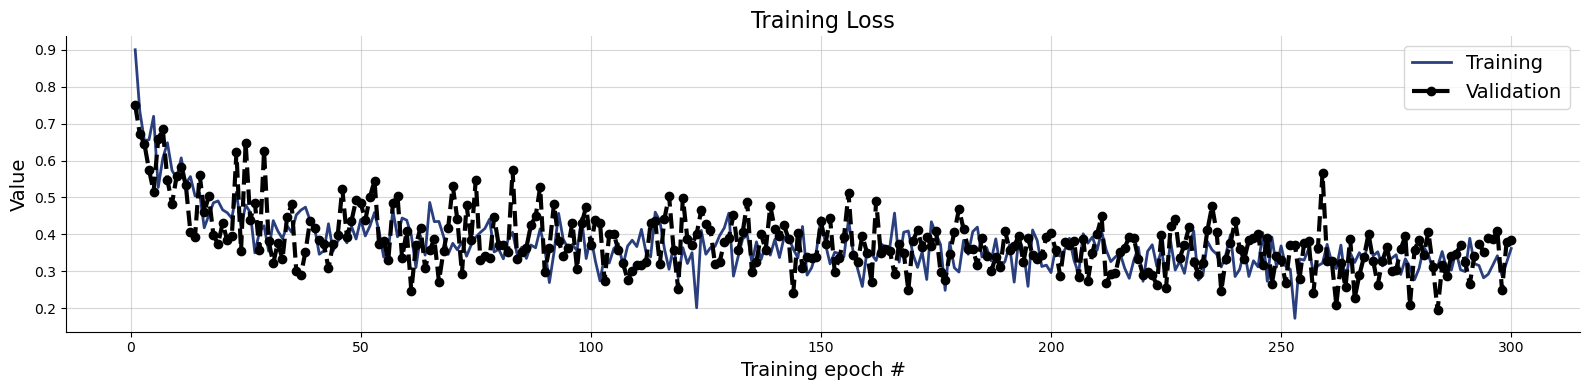

In [92]:
f = bf.diagnostics.plot_losses(
    train_losses=np.array(history.history["loss"]).astype(np.float32),
    val_losses=np.array(history.history["val_loss"]).astype(np.float32)
)

Great, it seems that our approximator has converged! Before we get too excited and throw our networks at real data, we need to make sure that they meet our expectations <em>in silico</em>, that is, given the small world of simulations the networks have seen during training.

## Validation Phase <a class="anchor" id="validation_phase"></a>


In [103]:
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate test data
test_sims = simulator.sample(300)
conditions = {k: v for k, v in test_sims.items() if k != "parameters"}

samples = approximator.sample(conditions=conditions, num_samples=num_samples)

### Simulation-Based Calibration - Rank Histograms <a class="anchor" id="simulation_based_calibration__"></a>

As a further <strong>small world</strong> (i.e., before real data) sanity check, we can also test the calibration of the amortizer through simulation-based calibration (SBC). See the corresponding paper by Sean Talts, Michael Betancourt, Daniel Simpson, Aki Vehtari, and Andrew Gelman for more details:

https://arxiv.org/pdf/1804.06788.pdf

Accordingly, we expect to observe approximately uniform rank statistic histograms.

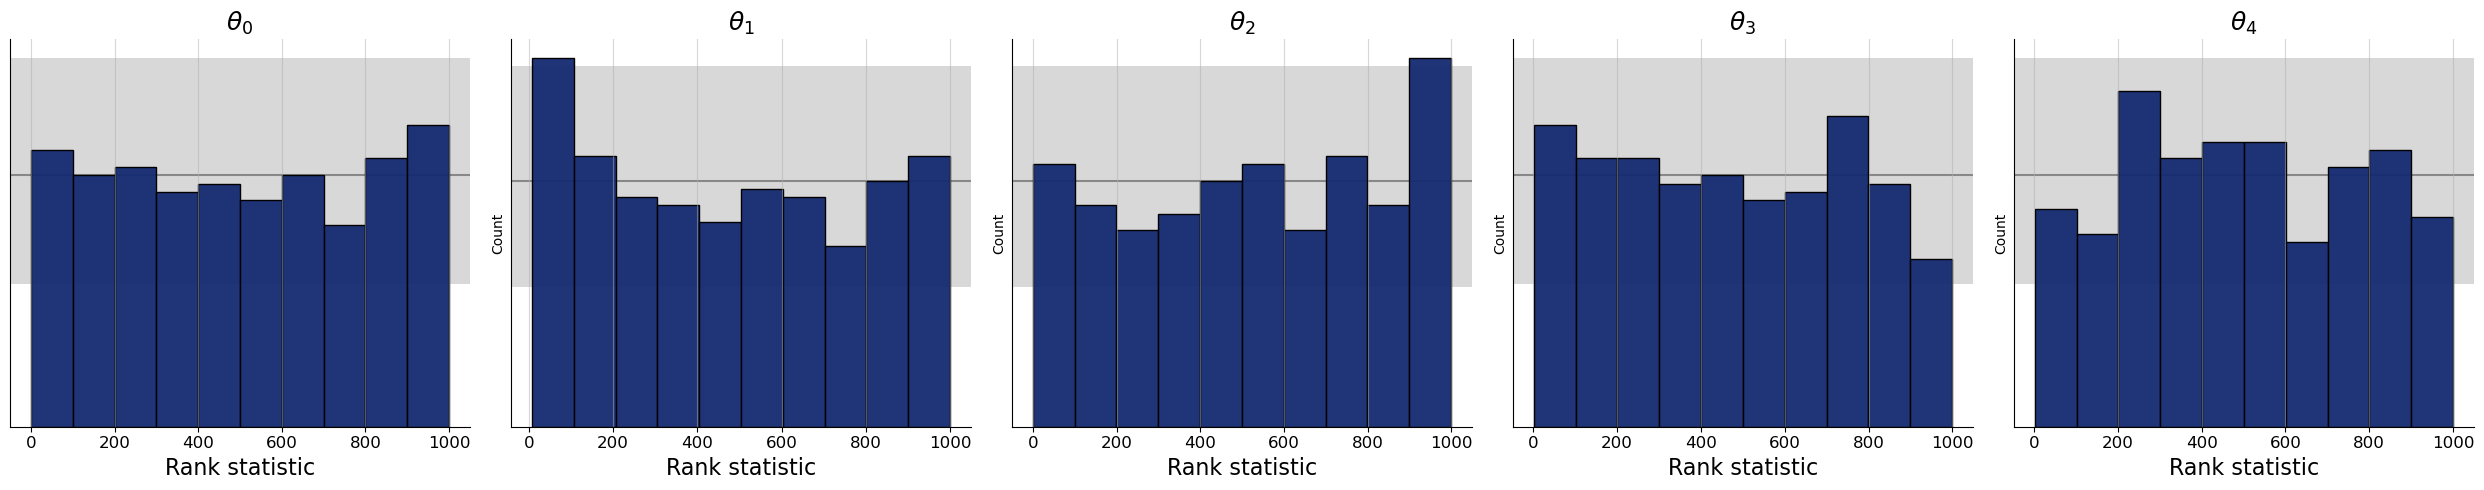

In [104]:
f = bf.diagnostics.plot_sbc_histograms(samples["parameters"], test_sims["parameters"])

### Simulation-Based Calibration - Rank ECDF <a class="anchor" id="simulation_based_calibration___0"></a>

For models with many parameters, inspecting many histograms can become unwieldly. Moreover, the `num_bins` hyperparameter for the construction of SBC rank histograms can be hard to choose. An alternative diagnostic approach for calibration is through empirical cumulative distribution functions (ECDF) of rank statistics. You can read more about this approach in the corresponding paper by Teemu Säilynoja, Paul-Christian Bürkner, and Aki Vehtari:

https://arxiv.org/abs/2103.10522

In order to inspect the ECDFs of marginal distributions, we will simulate $300$ new pairs of simulated data and generating parameters $(\boldsymbol{x}, \boldsymbol{\theta})$ and use the function `plot_sbc_ecdf` from the `diagnostics` module: 

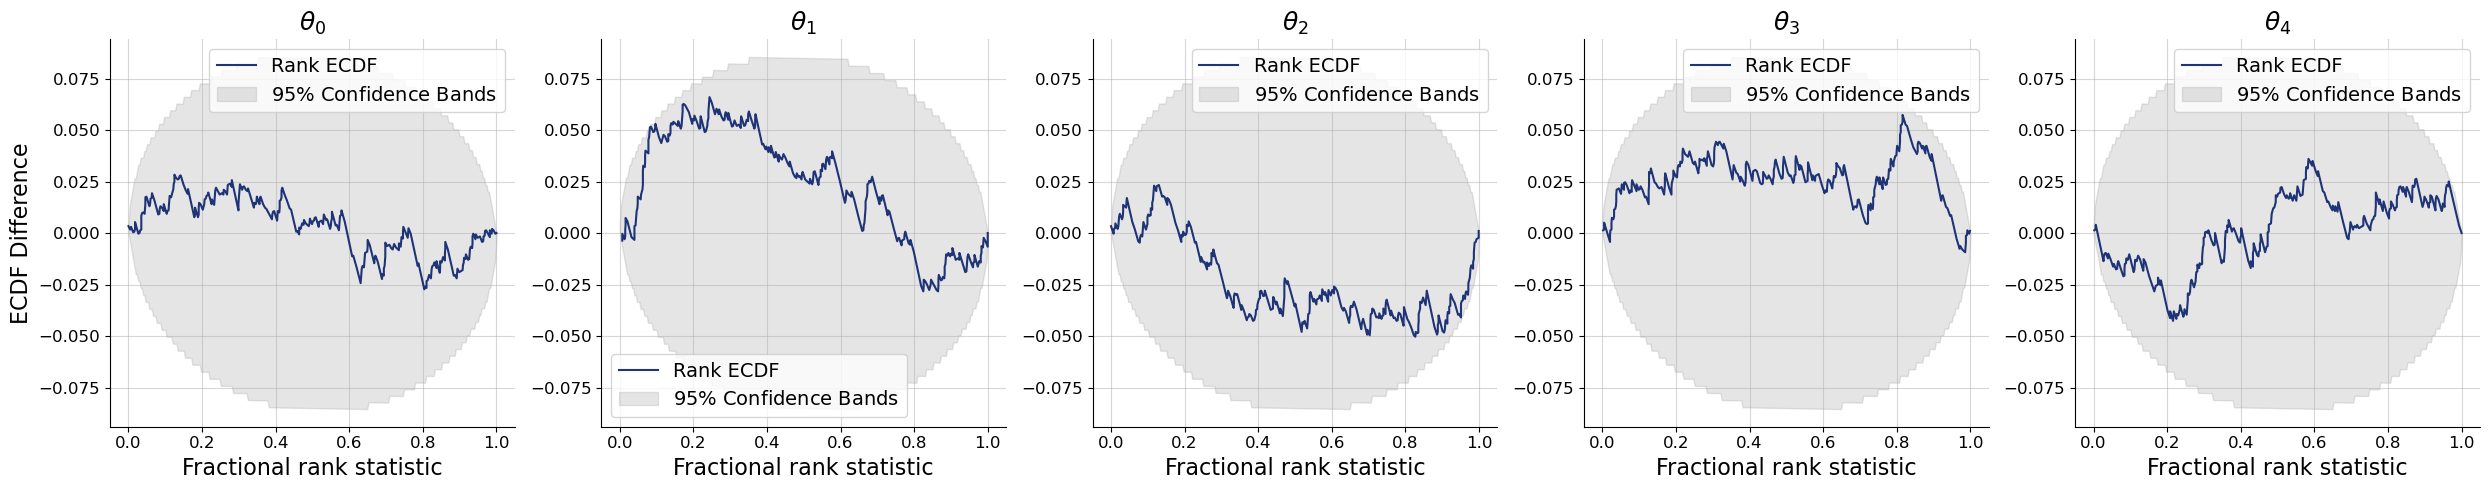

In [105]:
f = bf.diagnostics.plot_sbc_ecdf(samples["parameters"], test_sims["parameters"], difference=True)

### Inferential Adequacy (Global) <a class="anchor" id="inferential_adequacy__global_"></a>

Depending on the application, it might be interesting to see how well summaries of the full posterior (e.g., means, medians) recover the assumed true parameter values. We can test this <em>in silico</em> via the `plot_recovery` function in the `diagnostics` module. For instance, we can compare how well posterior means recover the true parameter (i.e., posterior z-score, https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html). Below, we re-use the $300$ simulations we took for computing the rank ECDFs, but obtain a larger number of posterior draws per data set for more stable results:

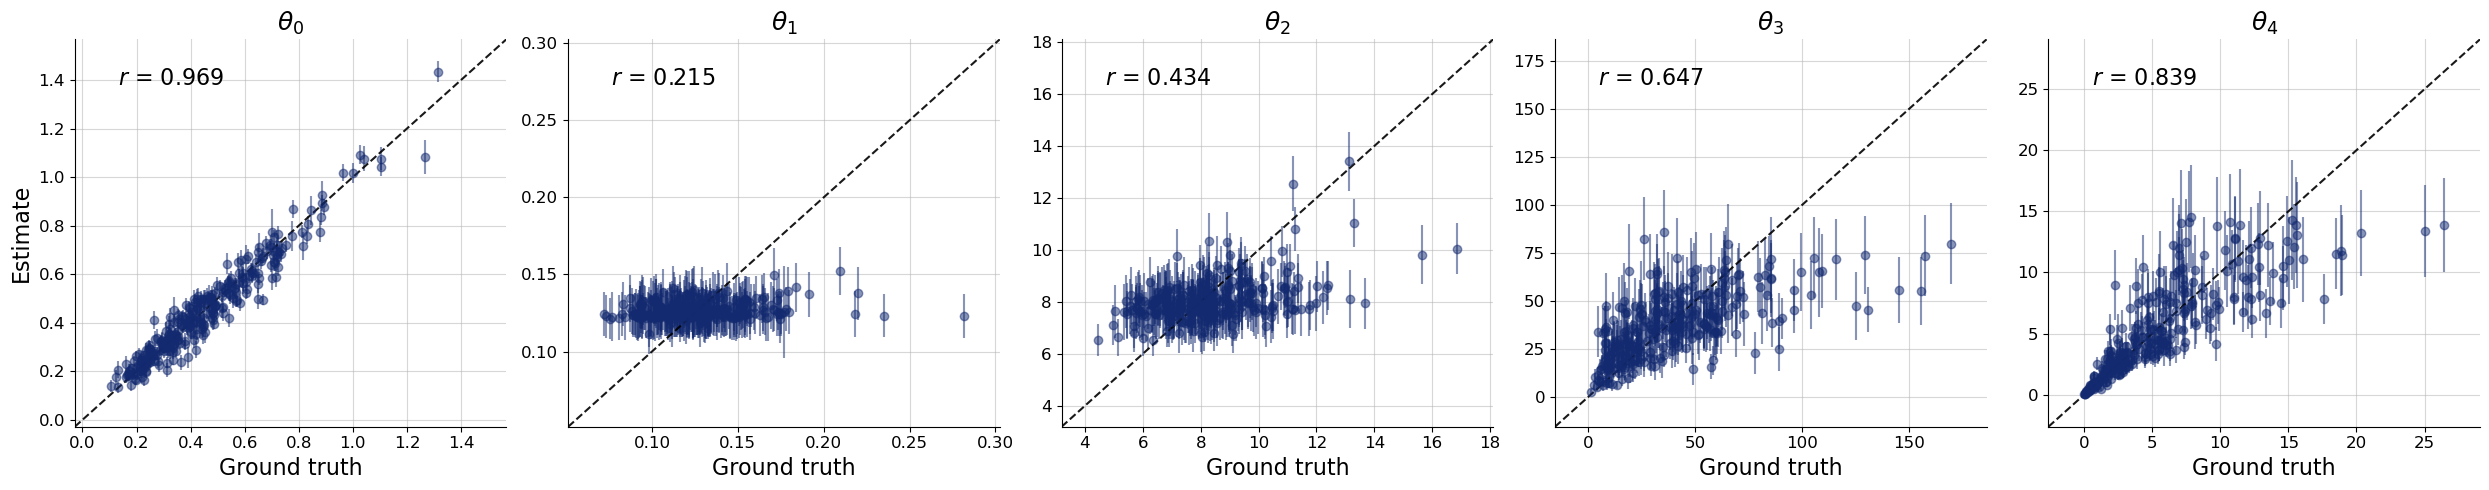

In [106]:
f = bf.diagnostics.plot_recovery(samples["parameters"], test_sims["parameters"])

## Inference Phase <a class="anchor" id="inference_phase"></a>

We can now move on to using real data. This is easy, and since we are using an adapter, the same transformations applied during training will be applied during the inference phase.

In [111]:
# Our loader returns a 1D array
obs_cases = load_data()

# Note that we transform the 1D array into shape (1, T, 1), indicating one time series
samples = approximator.sample(conditions={"cases": obs_cases[None, :, None]}, num_samples=num_samples)

### Posterior Retrodictive Checks <a class="anchor" id="posterior_retrodictive_checks"></a>

These are also called <em>posterior predictive checks</em>, but here we want to explicitly highlight the fact that we are not predicting future data but testing the <strong>generative performance</strong> or <strong>re-simulation performance</strong> of the model. In other words, we want to test how well the simulator can reproduce the actually observed data given the parameter posterior $p(\theta \mid x_{1:T})$. 

Here, we will create a custom function which plots the observed data and then overlays draws from the posterior predictive.

In [134]:
import matplotlib.pyplot as plt


def plot_ppc(samples, obs_cases, logscale=True, color="#132a70", dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams["font.size"] = font_size
    f, ax = plt.subplots(1, 1, figsize=figsize)
    T = len(obs_cases)

    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim
        sim_cases = stationary_SIR(samples[i])
        sims.append(sim_cases["cases"][:, 0])
    sims = np.array(sims)

    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)

    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label="Median predicted cases", color=color)
    ax.plot(obs_cases, marker="o", label="Reported cases", color="black", linestyle="dashed", alpha=0.8)

    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(T), qs_50[0], qs_50[1], color=color, alpha=0.5, label="50% CI")
    ax.fill_between(range(T), qs_90[0], qs_90[1], color=color, alpha=0.3, label="90% CI")
    ax.fill_between(range(T), qs_95[0], qs_95[1], color=color, alpha=0.1, label="95% CI")

    # Grid and schmuck
    ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Days since pandemic onset")
    ax.set_ylabel("Number of cases")
    ax.minorticks_off()
    if logscale:
        ax.set_yscale("log")
    ax.legend(fontsize=font_size)
    return f

We can now go on and plot the re-simulations:

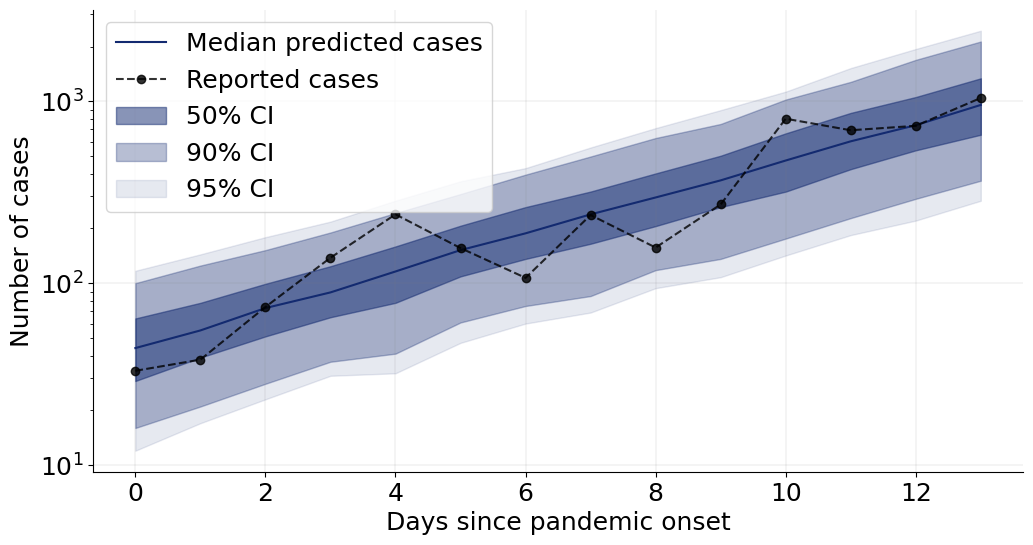

In [135]:
f = plot_ppc(samples["parameters"][0], obs_cases)

That's it for this tutorial! You now know how to use the basic building blocks of `BayesFlow` to create amortized neural approximators. :)

<!-- In the [next tutorial](./PriorSensitivity_Covid19_Initial.ipynb), we will go through a <strong>prior sensitivity analysis</strong> with `BayesFlow`, which is as easy to perform as it is important for ascertaining the robustness of our inferences. -->